In [ ]:
Class 14th June
Agenda: ReAct aegnt with multiple tools
ReAct: Reasoning and Action Agent 
using @tool decorator 


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [64]:
model="deepseek-r1-distill-llama-70b"

In [7]:
from langchain_groq import ChatGroq

In [8]:
llm = ChatGroq(model_name = model)

In [9]:
llm.invoke("Hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

Design Workflow for ReAct agent

In [106]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langgraph.graph.message import add_messages
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, MessagesState, START
from langgraph.prebuilt import ToolNode


In [65]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [67]:
HumanMessage("hi how are you?")

HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={})

In [68]:
HumanMessage(["hi how are you?"])

HumanMessage(content=['hi how are you?'], additional_kwargs={}, response_metadata={})

In [69]:

state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.192294028, 'prompt_time': 0.000194626, 'queue_time': 0.057462183, 'total_time': 0.192488654}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--7f600809-5b7f-48f7-87d2-f925666d9530-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

In [70]:
workflow = StateGraph(MessagesState)

In [71]:
workflow.add_node("my_bot", call_model)

In [72]:
workflow.add_edge(START, "my_bot")

In [73]:
workflow.add_edge("my_bot", END)

In [74]:
app = workflow.compile()

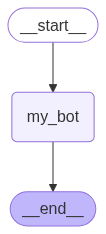

In [143]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [76]:
input = {"messages":["Hi, how are you?"]}

In [77]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='37ef2dc4-c710-4e9a-bb37-33a662539eab'),
  AIMessage(content="<think>\n\n</think>\n\nHi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.191007428, 'prompt_time': 0.000196147, 'queue_time': 0.054315263, 'total_time': 0.191203575}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--323c5961-c927-4bd4-8514-dd206f0a7a4f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

Create custom tool and use it in out workflow

In [79]:
from langchain_core.tools import tool

In [80]:
@tool
def search(query:str):
    """This is my custom tool for searching weather"""
    if "delhi" in query.lower():
        return "The temperature is 45 degree and sunny"
    return "Temperature is 25 degree and cloudy"

Check or test tool

In [83]:
search.invoke("What is temperature in Pune")

'Temperature is 25 degree and cloudy'

In [84]:
search.invoke("What is temperature in delhi")

'The temperature is 45 degree and sunny'

Bind tool in LLM

In [86]:
search

StructuredTool(name='search', description='This is my custom tool for searching weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025A5E20A160>)

In [87]:
tools = [search]

Bind tool (use good model for agent workflow since some open source models might not be good)

In [90]:
llm_with_tool = llm.bind_tools(tools) # bind tools takes list of tools

In [92]:
response = llm_with_tool.invoke("Whats is weather in delhi?")

In [93]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1smvzgb1n', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 241, 'prompt_tokens': 131, 'total_tokens': 372, 'completion_time': 1.083556326, 'prompt_time': 0.008523791, 'queue_time': 0.052897458999999994, 'total_time': 1.092080117}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09276b15-2798-4e39-98df-14e0f91a9a0f-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '1smvzgb1n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 241, 'total_tokens': 372})

In [94]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '1smvzgb1n',
  'type': 'tool_call'}]

In [95]:
response.content

''

Update the same function to call the tool with llm

In [191]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_with_tool.invoke(question)
    return {"messages":[response]}

In [192]:
input = {"messages":["What is weather in delhi"]}

In [193]:
response = call_model(input)

In [194]:
def router_function(state:MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [195]:
tools

[StructuredTool(name='search', description='This is my custom tool for searching weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025A5E20A160>)]

In [218]:
workflow_2 = StateGraph(MessagesState)

In [219]:
tool_node = ToolNode(tools)

In [220]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is my custom tool for searching weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025A5E20A160>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [221]:
workflow_2.add_node("llm_with_tool", call_model)
workflow_2.add_node("tools", tool_node)

In [222]:
workflow_2.add_edge(START,"llm_with_tool")
workflow_2.add_conditional_edges("llm_with_tool",
                                 router_function,
                                 {"tools":"tools",
                                  END:END})

In [223]:
app_2 = workflow_2.compile()

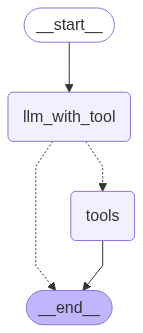

In [224]:
from IPython.display import Image,display
display(Image(app_2.get_graph().draw_mermaid_png()))

In [225]:
response = app_2.invoke({"messages":["What is weather In Bangalore"]})

In [226]:
response["messages"][-1].content

'Temperature is 25 degree and cloudy'

Add looping edge 

In [ ]:
workflow_2.add_edge("tools","llm_with_tool") # Now looping edge is added

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [228]:
app_3 = workflow_2.compile()

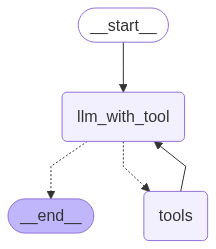

In [229]:
from IPython.display import Image,display
display(Image(app_3.get_graph().draw_mermaid_png()))

In [231]:
for output in app_3.stream({"messages":["What is weather in New delhi?"]}):
    for key, value in output.items():
        print("key is",{key})
        print("_______")
        print(value)
        print("\n")

key is {'llm_with_tool'}
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '312rd5sse', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 132, 'total_tokens': 299, 'completion_time': 0.719587822, 'prompt_time': 0.008443502, 'queue_time': 0.052483888, 'total_time': 0.728031324}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--56ecb8ae-6902-4cf9-a5ca-50ba7201506a-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in New Delhi'}, 'id': '312rd5sse', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 167, 'total_tokens': 299})]}


key is {'tools'}
_______
{'messages': [ToolMessage(content='The temperature is 45 degree and sunny', name='search', id='455b2668-392c-4d29-9fdb-05b0b6b3d749', tool_cal

Configure Memory

In [232]:
from langgraph.checkpoint.memory import MemorySaver

In [233]:
memory = MemorySaver()

In [234]:
workflow_3 = StateGraph(MessagesState)

In [235]:
workflow_3.add_node("llm_with_tool", call_model)
workflow_3.add_node("tools", tool_node)

In [236]:
workflow_3.add_edge("tools","llm_with_tool") # Now looping edge is added

In [237]:
workflow_3.add_edge(START,"llm_with_tool")
workflow_3.add_conditional_edges("llm_with_tool",
                                 router_function,
                                 {"tools":"tools",
                                  END:END})

In [238]:
app_4 = workflow_3.compile(checkpointer= memory)

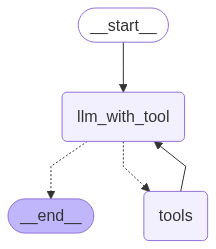

In [239]:
from IPython.display import Image,display
display(Image(app_4.get_graph().draw_mermaid_png()))

In [241]:
config = {"configurable":{"thread_id" : "1"}}

In [245]:
events = app_4.stream(
    {"messages":["What is weather in New delhi?"]}, config=config, stream_mode = "values")

In [246]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is weather in New delhi?
================================== Ai Message ==================================
Tool Calls:
  search (hngpjxgnm)
 Call ID: hngpjxgnm
  Args:
    query: New Delhi weather
================================= Tool Message =================================
Name: search

The temperature is 45 degree and sunny
================================== Ai Message ==================================
Tool Calls:
  search (esr5f8ybn)
 Call ID: esr5f8ybn
  Args:
    query: New Delhi weather
================================= Tool Message =================================
Name: search

The temperature is 45 degree and sunny
================================== Ai Message ==================================


In [247]:
events = app_4.stream(
    {"messages":["What is weather in Indore?"]}, config=config, stream_mode = "values")

In [248]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is weather in Indore?
================================== Ai Message ==================================
Tool Calls:
  search (4dmecev16)
 Call ID: 4dmecev16
  Args:
    query: Indore weather
================================= Tool Message =================================
Name: search

Temperature is 25 degree and cloudy
================================== Ai Message ==================================
Tool Calls:
  search (ynryy9jkx)
 Call ID: ynryy9jkx
  Args:
    query: Indore weather
================================= Tool Message =================================
Name: search

Temperature is 25 degree and cloudy
================================== Ai Message ==================================


In [249]:
memory

In [251]:
config

{'configurable': {'thread_id': '1'}}

In [253]:
memory.get(config) # Contain entire conversation

{'v': 3,
 'ts': '2025-06-14T05:39:40.821011+00:00',
 'id': '1f048e1f-7a67-6e92-8013-3d810bb7f0cf',
 'channel_versions': {'__start__': '00000000000000000000000000000016.0.8540785859981569',
  'messages': '00000000000000000000000000000021.0.4018863798143003',
  'branch:to:llm_with_tool': '00000000000000000000000000000021.0.4937252949987567',
  'branch:to:tools': '00000000000000000000000000000020.0.8738998512787501'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000015.0.43732123490424446'},
  'llm_with_tool': {'branch:to:llm_with_tool': '00000000000000000000000000000020.0.7641420163412095'},
  'tools': {'branch:to:tools': '00000000000000000000000000000019.0.5989736438669414'}},
 'channel_values': {'messages': [HumanMessage(content='What is weather in New delhi?', additional_kwargs={}, response_metadata={}, id='75ea6ece-497e-4db0-9ed8-5315060c72fa'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0c79w6rp9', 'function': {'

In [256]:
events = app_4.stream(
    {"messages":["In which city is temperature 25 degree?"]}, config=config, stream_mode = "values")

In [257]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In which city is temperature 25 degree?
================================== Ai Message ==================================

The temperature in **Indore** is 25 degrees and cloudy.
